## 데이터 처리와 분류

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


### Spectrogram 변환

librosa을 활용하여 1차원의 Waveform을 2차원의 Spectrogram로 변경합니다.

In [3]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [4]:
data = speech_data["wav_vals"]
specs = []
for i in range(len(data)):
    spec = wav2spec(data[i])
    specs.append(spec)

In [5]:
specs = np.array(specs)

In [6]:
print("Waveform shape : ",data.shape)
print("Waveform len : ",len(data))
print("Spectrogram shape : ",specs.shape)
print("Spectrogram len : ",len(specs))

Waveform shape :  (50620, 8000)
Waveform len :  50620
Spectrogram shape :  (50620, 130, 126)
Spectrogram len :  50620


모든 데이터가 2차원 Spectrogram 데이터로 변경된 모습을 확인할 수 있습니다.

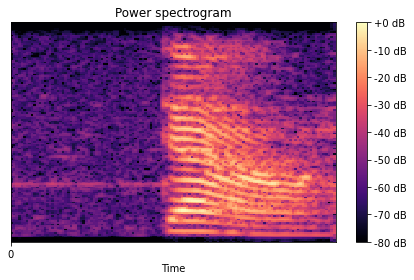

In [7]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(specs[2], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

위의 그림과 같이 X축은 시간, Y축은 주파수를 나타내며, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현됩니다.

In [8]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [9]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

In [10]:
label_data.shape

(50620,)

In [11]:
from sklearn.model_selection import train_test_split

xr = specs.shape[1]
yr = specs.shape[2]
train_wav, test_wav, train_label, test_label = train_test_split(specs, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

train_wav = train_wav.reshape([-1, xr, yr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, xr, yr, 1])

In [12]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)


## 학습을 위한 하이퍼파라미터 설정 

In [13]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

checkpoint_dir

'/home/aiffel0042/aiffel/speech_recognition/models/wav_skip'

## 데이터셋 구성

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [15]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 2차원 모델 구성

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(xr, yr, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)       

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7734
Epoch 00001: val_loss improved from inf to 0.37468, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 200s 140ms/step - loss: 0.6836 - accuracy: 0.7734 - val_loss: 0.3747 - val_accuracy: 0.8825
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9241
Epoch 00002: val_loss improved from 0.37468 to 0.20603, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 202s 142ms/step - loss: 0.2389 - accuracy: 0.9241 - val_loss: 0.2060 - val_accuracy: 0.9335
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9471
Epoch 00003: val_loss improved from 0.20603 to 0.16570, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] 

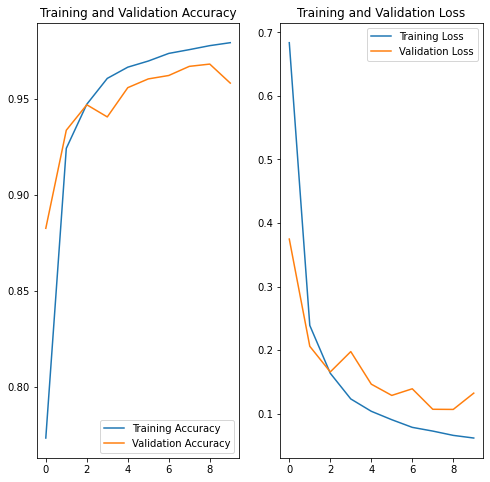

In [21]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

성공적으로 수렴하는 모습을 볼 수 있습니다. 

In [23]:
# Evaluation 

model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 18s 113ms/step - loss: 0.1066 - accuracy: 0.9680
loss value: 0.107
accuracy value: 96.7997%


In [26]:
import IPython.display as ipd

In [28]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  go


In [29]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: go


## Report

1차원의 데이터를 학습시키는 것 보다 2차원의 waveform으로 학습시키는 것이 결과가 더 좋았습니다.  
시간 축에서만 보는 것 보다 X축은 시간, Y축은 주파수를 나타냈기 때문에 관련된 특징을 더 잘 학습하는 것 같습니다.  